# Dolly Zoom

This project is based on Robotics:Perception Assignment 1 by University of Pennsylvania on Coursera. (https://www.coursera.org/learn/robotics-perception)

We will implement Dolly Zoom effect used by filmmakers to create a sensation of vertigo, a “falling-away-from-oneself feeling”.  This effect keeps the size of an object of interests constant in the image, while making the foreground and background objects appear larger or smaller by adjusting focal length and moving the camera. Please find an example of the Dolly Zoom simulation from this link: http://cis.upenn.edu/~cis580/Spring2016/Projects/output.avi

In [161]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import numpy as np
import glob
import os
import cv2

from utils import load_image, PIL_resize, rgb2gray, normalize_img, verify
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 0 : Load Images

['./data/boat1\\boat_001.jpg', './data/boat1\\boat_002.jpg', './data/boat1\\boat_003.jpg', './data/boat1\\boat_004.jpg', './data/boat1\\boat_005.jpg', './data/boat1\\boat_006.jpg', './data/boat1\\boat_007.jpg', './data/boat1\\boat_008.jpg', './data/boat1\\boat_009.jpg', './data/boat1\\boat_010.jpg', './data/boat1\\boat_011.jpg', './data/boat1\\boat_012.jpg', './data/boat1\\boat_013.jpg', './data/boat1\\boat_014.jpg', './data/boat1\\boat_015.jpg']


<IPython.core.display.Javascript object>


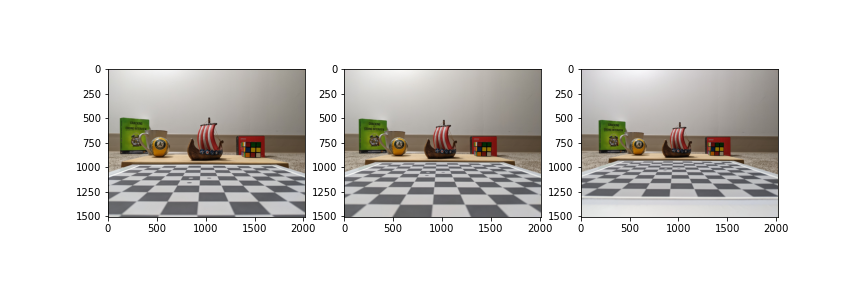

In [162]:
# Load bottle images

imageFnames = glob.glob('./data/boat1/*.jpg')
imageSet = np.zeros(len(imageFnames), dtype=object)

print(imageFnames)

scale = 0.5

for i in range(len(imageFnames)):
    img = load_image(imageFnames[i])
    new_width = int(np.shape(img)[1] * scale)
    new_height = int(np.shape(img)[0] * scale)

    img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_AREA)
    imageSet[i] = img

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imageSet[0])
plt.subplot(1,3,2)
plt.imshow(imageSet[1])
plt.subplot(1,3,3)
plt.imshow(imageSet[2])

## Part 1 : Extract object of interest

In [163]:
from functions import Get_matches, Get_matches2
from BBWidget import Open_BB_widget

img_object = imageSet[0]
scale2 = 0.25
new_width = int(np.shape(img)[1] * scale2)
new_height = int(np.shape(img)[0] * scale2)

scaled_img = cv2.resize(imageSet[0], (new_width, new_height), interpolation = cv2.INTER_AREA)

scaled_coordinates = Open_BB_widget(scaled_img)
coordinates = (np.array(scaled_coordinates) * (1/scale2)).astype(np.int)

A new window has opened
Drag to create a bounding box
You can redraw a bounding box if needed
Press Q to save and exit
top left: (194, 115), bottom right: (303, 237)
x,y,w,h : (194, 115, 109, 122)


[[ 776  460]
 [1212  948]]


<IPython.core.display.Javascript object>


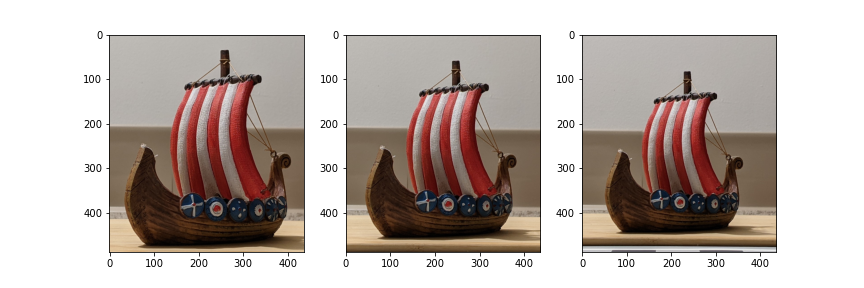

In [164]:
print(coordinates)
(x,y) = coordinates[0]
(w,h) = coordinates[1]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imageSet[0][y:h,x:w,:])
plt.subplot(1,3,2)
plt.imshow(imageSet[1][y:h,x:w,:])
plt.subplot(1,3,3)
plt.imshow(imageSet[2][y:h,x:w,:])

## Part 2 : Calculate Homography matrix between the two images

In [165]:
pts_a, pts_b = Get_matches2(imageSet[0][y:h,x:w,:], imageSet[1][y:h,x:w,:], 50)

In [166]:
from utils import show_correspondence2
newImg = show_correspondence2(imageSet[0][y:h,x:w,:], imageSet[1][y:h,x:w,:], pts_a[:,0], pts_a[:,1], pts_b[:,0], pts_b[:,1])

<IPython.core.display.Javascript object>


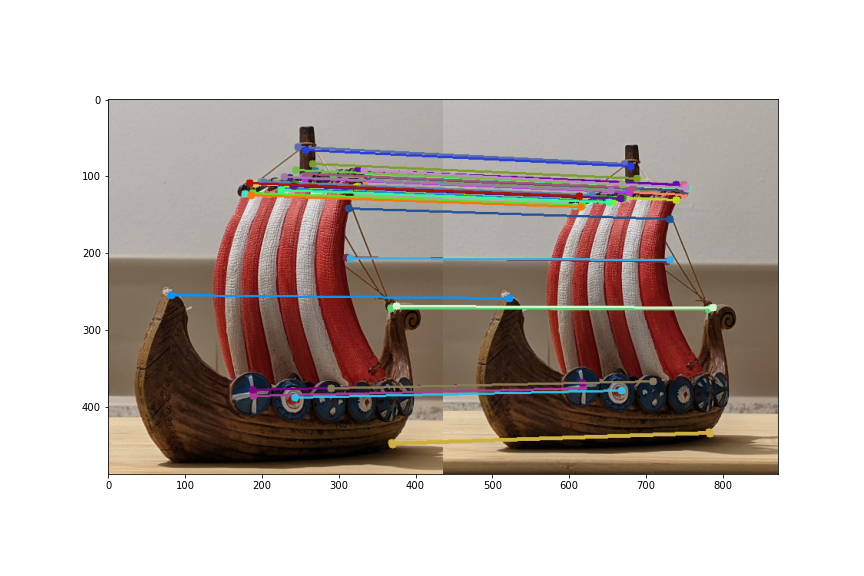

In [167]:
plt.figure(figsize=(12,8))
plt.imshow(newImg)

In [168]:
from functions import Get_homography_matrix, Apply_transform

transform = Get_homography_matrix(pts_b, pts_a)

In [169]:
new_img = Apply_transform(imageSet[1][y:h,x:w,:], transform, imageSet[0][y:h,x:w,:])

<IPython.core.display.Javascript object>


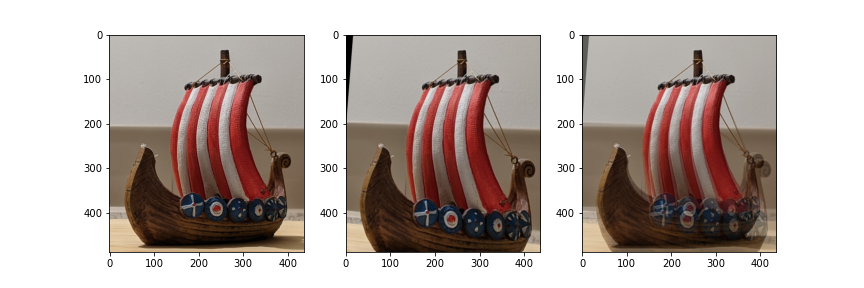

In [170]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imageSet[0][y:h,x:w,:])
plt.subplot(1,3,2)
plt.imshow(new_img)
plt.subplot(1,3,3)
plt.imshow(new_img/2 + imageSet[0][y:h,x:w,:]/2)

## Part 3 : Repeat this process for multiple images using a mask instead of crop

In [173]:
mask = np.zeros_like(imageSet[0][:,:,0]).astype(np.uint8)
mask[y:h,x:w] = 255

processedImageSet = np.zeros(len(imageFnames), dtype=object)
processedImageSet[0] = imageSet[0].copy()

for i in range(len(imageFnames) -1):
    pts_a, pts_b = Get_matches2(processedImageSet[i], imageSet[i+1], 100, mask)
    transform = Get_homography_matrix(pts_b, pts_a)
    new_img = Apply_transform(imageSet[i+1], transform, processedImageSet[i])
    processedImageSet[i+1] = new_img

## Part 4 : Save images as a gif

In [174]:
from PIL import Image

gif_set = []

for i in range(len(imageFnames)):
    im = Image.fromarray(np.uint8(processedImageSet[len(imageFnames) -1 - i]*255))
    gif_set.append(im)

gif_set_boomerang = gif_set

for i in range(len(imageFnames)):
    gif_set_boomerang.append(gif_set[len(imageFnames) -1 - i])
    
gif_set[0].save('dolly_zoom_boat1.gif', save_all=True, append_images=gif_set[1:], optimize=False, duration=100, loop=0)